<a href="https://colab.research.google.com/github/itsmebebe/20242R0136COSE47402/blob/main/TFT_Hard_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import math
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
loss: 0.031140: 100%|██████████| 100/100 [00:11<00:00,  8.68it/s]


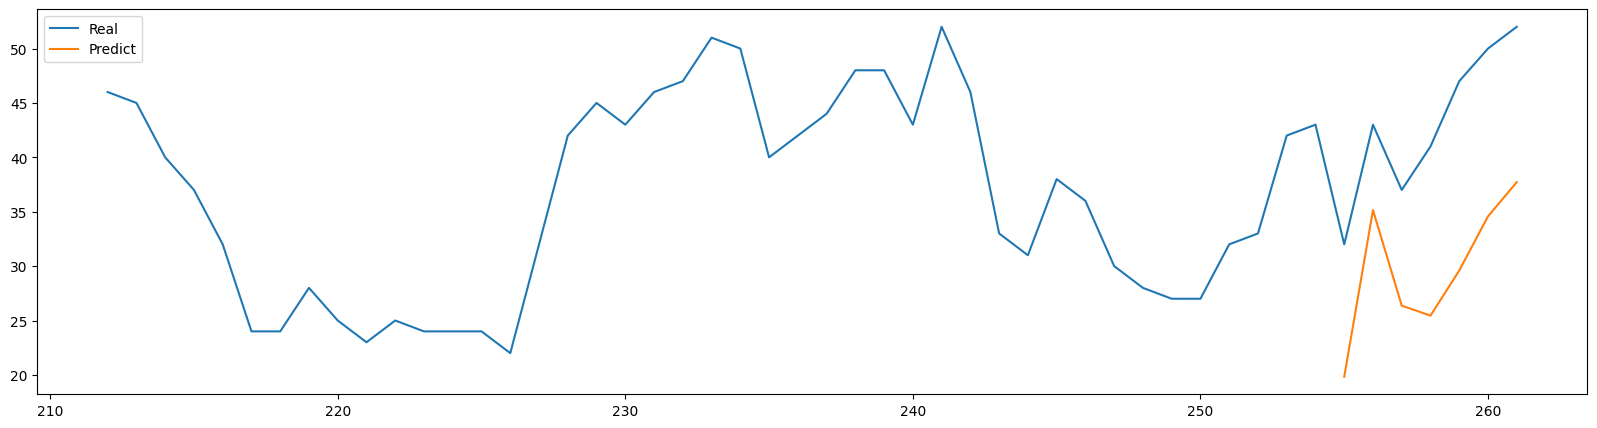

In [3]:
# 데이터 로드 및 준비
df = pd.read_csv("/content/TimeSeries_Projectdata_PublicSentiment.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# Justice 열만 사용
df = df[['Justice']]

# MinMaxScaler 적용
min_max_scaler = MinMaxScaler()
df['Justice'] = min_max_scaler.fit_transform(df['Justice'].to_numpy().reshape(-1, 1))

# Train/Test 데이터 분리
train = df[:-10]
data_train = train['Justice'].to_numpy()

test = df[-10:]
data_test = test['Justice'].to_numpy()

# Dataset 클래스 정의
class windowDataset(Dataset):
    def __init__(self, y, input_window=14, output_window=7, stride=1):
        L = y.shape[0]
        num_samples = (L - input_window - output_window) // stride + 1

        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride * i
            end_x = start_x + input_window
            X[:, i] = y[start_x:end_x]

            start_y = stride * i + input_window
            end_y = start_y + output_window
            Y[:, i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1, 0, 2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1, 0, 2))
        self.x = X
        self.y = Y
        self.len = len(X)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

    def __len__(self):
        return self.len


# Input/Output 윈도우 설정
iw = 14  # 입력 윈도우: 14주 (약 3개월)
ow = 7   # 출력 윈도우: 7주 (약 2개월)

train_dataset = windowDataset(data_train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)

# Transformer 모델 정의
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TFModel(nn.Module):
    def __init__(self, iw, ow, d_model, nhead, nlayers, dropout=0.5):
        super(TFModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayers)
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        self.encoder = nn.Sequential(
            nn.Linear(1, d_model // 2),
            nn.ReLU(),
            nn.Linear(d_model // 2, d_model)
        )

        self.linear = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Linear(d_model // 2, 1)
        )

        self.linear2 = nn.Sequential(
            nn.Linear(iw, (iw + ow) // 2),
            nn.ReLU(),
            nn.Linear((iw + ow) // 2, ow)
        )

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, srcmask):
        src = self.encoder(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src.transpose(0, 1), srcmask).transpose(0, 1)
        output = self.linear(output)[:, :, 0]
        output = self.linear2(output)
        return output


# 모델 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 1e-4
model = TFModel(iw, ow, 512, 8, 4, 0.1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

epoch = 100
model.train()
progress = tqdm(range(epoch))
for i in progress:
    batch_loss = 0.0
    for (inputs, outputs) in train_loader:
        optimizer.zero_grad()
        src_mask = model.generate_square_subsequent_mask(inputs.shape[1]).to(device)
        result = model(inputs.float().to(device), src_mask)
        loss = criterion(result, outputs[:, :, 0].float().to(device))
        loss.backward()
        optimizer.step()
        batch_loss += loss
    progress.set_description("loss: {:0.6f}".format(batch_loss.cpu().item() / len(train_loader)))

# 평가
def evaluate():
    input = torch.tensor(data_train[-iw:]).reshape(1, -1, 1).to(device).float()
    model.eval()
    src_mask = model.generate_square_subsequent_mask(input.shape[1]).to(device)
    predictions = model(input, src_mask)
    return predictions.detach().cpu().numpy()

result = evaluate()
result = min_max_scaler.inverse_transform(result)[0]
real = df['Justice'].to_numpy()
real = min_max_scaler.inverse_transform(real.reshape(-1, 1))[:, 0]

# 결과 시각화
plt.figure(figsize=(20, 5))
plt.plot(range(len(real) - 50, len(real)), real[-50:], label="Real")
plt.plot(range(len(real) - ow, len(real)), result, label="Predict")
plt.legend()
plt.show()
